<a href="https://colab.research.google.com/github/ahmedlabib02/Nlp-project/blob/main/Nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 1

In [ ]:
# %pip install transformers
# %pip install nltk
# %pip install farasapy
# %pip install --quiet camel-tools-data
# %pip install camel-tools
# %pip install camel-tools -f https://download.pytorch.org/whl/torch_stable.html

%pip install arabic-reshaper
%pip install python-bidi
%pip install wordcloud
# %pip install WordCloud
# %pip install --upgrade -f https://download.pytorch.org/whl/torch_stable.html camel-tools

In [96]:
import os 
import json
import re
import pandas as pd
from collections import Counter
import string
from wordcloud import WordCloud
from transformers import BertTokenizer
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from farasa.segmenter import FarasaSegmenter
from nltk.stem.isri import ISRIStemmer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
segmenter = FarasaSegmenter(interactive=False)
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Labib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data preparation

#### Unzipping the "B Hodoo2" channel folder

In [4]:
import zipfile
zip_path = "./B Hodoo2-20250226T182935Z-001.zip"
extract_path = "./"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


#### Unzipping the "Kefaya ba2a" channel folder

In [5]:
import zipfile
zip_path = "./Kefaya Ba2a-20250226T183527Z-001.zip"
extract_path = "./"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Building dict for annotations and text

In [6]:
def standardize(title):
    
    title = title.replace("_", " ")
   
    title = title.lower()
    
    title = re.sub(r'[^\w\s]', '', title)
    
    # title = re.sub(r'\bبودكاست بهدوء مع كريم\b', '', title)
    # title = re.sub(r'\bجلسة\b', '', title)
    
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [7]:
def get_category_for_filename(target_filename, annotations_path):
    """
    Load annotations from annotations_path and try to match the
    canonicalized target_filename (without file extension) to the canonicalized
    title from each annotation. If a match is found, return the annotation's category.
    """
    with open(annotations_path, 'r', encoding='utf-8') as f_json:
        annotations = json.load(f_json)
    
    base_target = os.path.splitext(target_filename)[0]
    target_can = standardize(base_target)
    for entry in annotations:
        annotation_title = entry.get('title')
        if annotation_title:
            
            annotation_can = standardize(annotation_title)
            if annotation_can == target_can:
                # print("Matched annotation:", entry.get('title'))
                return entry.get('category')
    return None

In [8]:
def add_transcripts_from_folder(transcripts_dict, folder_path, channel):
    
    annotations_json = os.path.join(folder_path, 'annotations.json')
    raw_folder = os.path.join(folder_path, 'raw')
    for filename in os.listdir(raw_folder):
        full_path = os.path.join(raw_folder, filename)
        if os.path.isfile(full_path):
            with open(full_path, 'r', encoding='utf-8') as file:
                transcript = file.read()
                category = get_category_for_filename(filename, annotations_json)
            base_filename, _ = os.path.splitext(filename)
            transcripts_dict[base_filename] = (channel, category, transcript)
    return transcripts_dict

In [9]:
transcripts_dict = {}
first_folder_path = './B Hodoo2/'
second_folder_path = './Kefaya Ba2a/'

transcripts_dict = add_transcripts_from_folder(transcripts_dict, first_folder_path,  'B Hodoo2')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, second_folder_path, 'Kefaya Ba2a')



### Creating a dataframe

In [10]:
data = [(title, info[0], info[1], info[2]) for title, info in transcripts_dict.items()]
df = pd.DataFrame(data, columns=['title', 'channel', 'category', 'transcript'])
print(df.head())


                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...  
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...  
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...  
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...  
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...  


### Before pre-processing analysis

**Reveals the number of rows and columns, data types of each column, and non-null counts.**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       48 non-null     object
 1   channel     48 non-null     object
 2   category    47 non-null     object
 3   transcript  48 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB


**Identifying which columns have missing values**

In [12]:
print(df.isnull().sum())

title         0
channel       0
category      1
transcript    0
dtype: int64


**Since there are some entries without categories or an annotation file, we just remove them.**

In [13]:
df = df[df['category'].notna()]

**Measuring number of transcript and exploring outliers**

In [14]:
df['raw_length'] = df['transcript'].apply(len)
print(df['raw_length'].describe())

count       47.000000
mean     21778.021277
std       9970.770825
min        930.000000
25%      17160.500000
50%      20942.000000
75%      25980.500000
max      51920.000000
Name: raw_length, dtype: float64


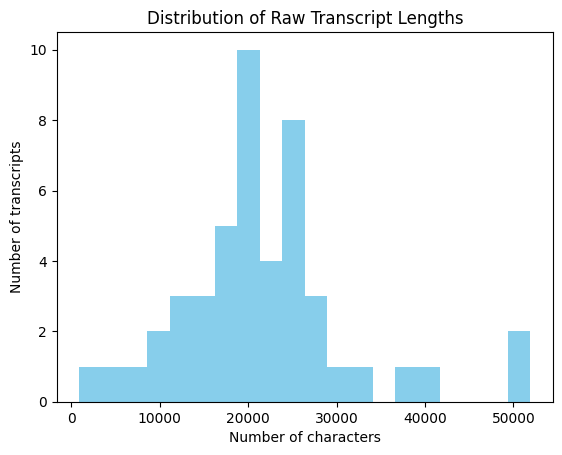

In [15]:
import matplotlib.pyplot as plt

plt.hist(df['raw_length'], bins=20, color='skyblue')
plt.xlabel("Number of characters")
plt.ylabel("Number of transcripts")
plt.title("Distribution of Raw Transcript Lengths")
plt.show()

category
Education         26
People & Blogs    17
Comedy             4
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

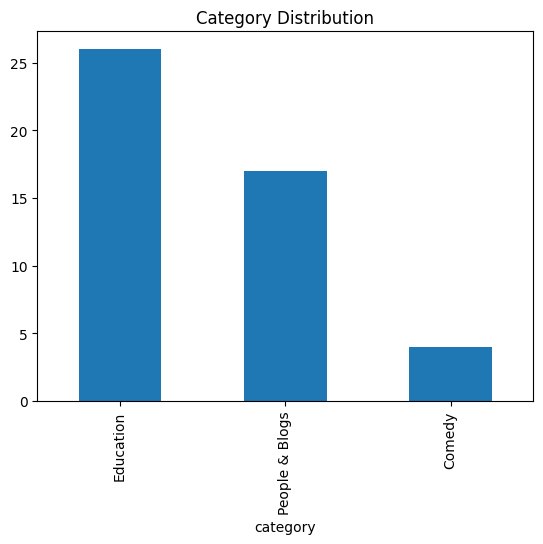

In [16]:
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar', title='Category Distribution')

In [17]:
print(df['channel'].unique())
print(df['channel'].value_counts())

['B Hodoo2' 'Kefaya Ba2a']
channel
B Hodoo2       26
Kefaya Ba2a    21
Name: count, dtype: int64


**Viewing most common words before preprocessing**

In [18]:
all_text = " ".join(df['transcript'])
words = all_text.split()
word_freq = Counter(words)
print("Top 10 most common words in raw transcripts:")
print(word_freq.most_common(10))

Top 10 most common words in raw transcripts:
[('في', 5726), ('انا', 3823), ('ما', 3330), ('اللي', 3253), ('ده', 2993), ('انت', 2853), ('من', 2737), ('ان', 2699), ('هو', 2628), ('يعني', 2494)]


**Viewing the most common words per category**

In [19]:
def top_words_for_category(cat, n=10):
    subset = df[df['category'] == cat]
    combined_text = " ".join(subset['transcript'])
    words = combined_text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)
categories = df['category'].unique()
for cat in categories:
    print(f"Category: {cat}")
    top_words = top_words_for_category(cat, n=5)
    for word, count in top_words:
        print(f"  {word}: {count}")

Category: Education
  في: 3018
  انا: 2115
  اللي: 1838
  ان: 1789
  من: 1780
Category: People & Blogs
  في: 2135
  انت: 1332
  انا: 1327
  ما: 1285
  هو: 1259
Category: Comedy
  في: 573
  ما: 399
  يا: 391
  انا: 381
  انت: 364


### Cleaning the data

#### Removing numbers, non-Arabic letters and extra spaces

In [20]:
def clean_text(text):
    punctuations = string.punctuation + "؟،؛«»…ـ"  
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)  
    text = re.sub(r'[0-9A-Za-z]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [21]:
df["clean_transcript"] = df["transcript"].apply(clean_text)
print(df.head())

                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  raw_length  \
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...       21032   
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...       18261   
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...       18546   
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...       23874   
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...       11462   

                                    clean_transcript  
0  النهارده الفيديو بتاعنا على الانتاجيه لان النه...  
1  انا النهارده جا

### Tokenization 

In [58]:
def bert_tokenize(df):
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    df['bert_tokens'] = df['clean_transcript'].apply(lambda x: tokenizer.tokenize(str(x)))
bert_tokenize(df)
print(df["bert_tokens"].head())

0    [ال, ##نها, ##رد, ##ه, ال, ##فيد, ##يو, ب, ##ت...
1    [ان, ##ا, ال, ##نها, ##رد, ##ه, جا, ##ي, ا, ##...
2    [ال, ##نها, ##رد, ##ه, ان, ##ا, جا, ##ي, ا, ##...
3    [ب, ##صر, ##اح, ##ه, ان, ##ا, موضوع, ان, ا, ##...
4    [م, ##ساء, ال, ##فل, ال, ##فيد, ##يو, ده, عن, ...
Name: bert_tokens, dtype: object


**We will use more dialect specific tokenizers using libraries like Farasa**

In [23]:
def farasa_tokenize(text):
    text = str(text)
    segmented_text = segmenter.segment(text)
    tokens = segmented_text.split()
    return tokens

df['farasa_tokens'] = df['transcript'].apply(farasa_tokenize)
df['farasa_tokens'] 

0     [النهارده, ال+فيديو, بتاع+نا, على, ال+انتاجيه,...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحد+ه, من, أ...
3     [ب+صراح+ه, أنا, موضوع, ان, اح+نا, مش, عارف+ين,...
4     [مساء, ال+فل, ال+فيديو, ده, عن, ال+رزق, لو, أن...
6     [عند+نا, في, مصر, ل+ما, ب+يبقى, في, حد, ال+دني...
7     [مافيش, حد, في+نا, الا, و+في, حيا+ت+ه, نسب+ه, ...
8     [يدخل, ال+بيت, فبيقول, ل+ها, و+صف+ي, لي, ال+حر...
9     [النهارده, أنا, جاي, اكلم+ك, في, موضوع, في, من...
10    [ال+حلقه, دي, بقى, ب+ال+ذات, أنا, دائم+ا, يا, ...
11    [من, حوالي, سبع, سن+ين, واحد+ه, كتب+ت, لي, في,...
12    [ال+سلام, علي+كم, و+رحم+ه, أنت, ازاي, تدخل, عل...
13    [أول, يا, جماع+ه, ل+ما, ب+تقول, الله, هو, من, ...
14    [طبع+ا, ك+ال+عاده, اح+نا, اتعودنا, ان, اي, فيد...
15    [النهارده, أنا, ب+هدي, ال+حلقه, دي, ل+نفس+ي, أ...
16    [ينفع, اشارككم, حاج+ه, ب+دون, مثالي+ه, عاليه, ...
17    [وكالعاده, مستمر+ين, في, ال+تمرد, على, ال+غوري...
18    [اهل+ا, و+سهل+ا, ب+كم, في, ال+جزء, ال+تاني

**Plus signs generated with farasa tokenizition may introduce noise so we remove them**

In [60]:
def remove_plus_signs(tokens):
    return [token.replace('+', '') for token in tokens]

df['farasa_tokens'] = df['farasa_tokens'].apply(remove_plus_signs)
df['farasa_tokens']

0     [النهارده, الفيديو, بتاعنا, على, الانتاجيه, لا...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحده, من, أخ...
3     [بصراحه, أنا, موضوع, ان, احنا, مش, عارفين, نتب...
4     [مساء, الفل, الفيديو, ده, عن, الرزق, لو, أنت, ...
6     [عندنا, في, مصر, لما, بيبقى, في, حد, الدنيا, م...
7     [مافيش, حد, فينا, الا, وفي, حياته, نسبه, من, ا...
8     [يدخل, البيت, فبيقول, لها, وصفي, لي, الحرامي, ...
9     [النهارده, أنا, جاي, اكلمك, في, موضوع, في, منت...
10    [الحلقه, دي, بقى, بالذات, أنا, دائما, يا, جماع...
11    [من, حوالي, سبع, سنين, واحده, كتبت, لي, في, ال...
12    [السلام, عليكم, ورحمه, أنت, ازاي, تدخل, عليا, ...
13    [أول, يا, جماعه, لما, بتقول, الله, هو, من, فعل...
14    [طبعا, كالعاده, احنا, اتعودنا, ان, اي, فيديو, ...
15    [النهارده, أنا, بهدي, الحلقه, دي, لنفسي, أولا,...
16    [ينفع, اشارككم, حاجه, بدون, مثاليه, عاليه, ومب...
17    [وكالعاده, مستمرين, في, التمرد, على, الغوريزم,...
18    [اهلا, وسهلا, بكم, في, الجزء, التاني, من, 

### Stop word removal

**Analysing the stop word removal in each in transcript**

In [61]:
arabic_stopwords = set(stopwords.words('arabic'))

In [62]:
def count_stopwords(tokens, stopwords_set):
    return sum(1 for token in tokens if token in stopwords_set)

In [65]:
# df['stopword_count'] = df['farasa_tokens'].apply(lambda tokens: count_stopwords(tokens, arabic_stopwords))
df['total_tokens'] = df['farasa_tokens'].apply(len)

# print(df[['stopword_count', 'total_tokens']].head())

**Removing the stop words**

In [70]:
def remove_stopwords(tokens, stopwords_set):
    return [token for token in tokens if token not in stopwords_set]

In [71]:
df['tokens_no_stop'] = df['farasa_tokens'].apply(lambda tokens: remove_stopwords(tokens, arabic_stopwords))
df['total_tokens_no_stop'] = df['tokens_no_stop'].apply(len)
print(df[['total_tokens', 'total_tokens_no_stop']].head())

   total_tokens  total_tokens_no_stop
0          4192                  3242
1          3652                  2883
2          3532                  2756
3          4657                  3607
4          2308                  1756


### Removing custom egyptian stop words


In [72]:
vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = vectorizer.fit_transform(df['clean_transcript'])
idf = vectorizer.idf_
terms = vectorizer.get_feature_names_out()
term_idf = list(zip(terms, idf))
common_words = [term for term, score in term_idf if score < np.percentile(idf, 5)]
print("Candidate stopwords based on low IDF:", common_words)


Candidate stopwords based on low IDF: ['اب', 'ابتدت', 'ابتدى', 'ابتدي', 'ابتديت', 'ابدا', 'ابراهيم', 'ابسط', 'ابص', 'ابقى', 'ابن', 'ابني', 'ابو', 'ابويا', 'ابيض', 'اتس', 'اتفرج', 'اتكلم', 'اتكلمت', 'اتكلمنا', 'اتمنى', 'اثنين', 'اجري', 'اجي', 'اجيب', 'احد', 'احساس', 'احسن', 'احمد', 'احنا', 'احيانا', 'اختبار', 'اخد', 'اخر', 'اخرى', 'اخش', 'اخويا', 'اخي', 'ادي', 'اذا', 'ارباع', 'اربع', 'اربعه', 'ارجع', 'اروح', 'از', 'ازاي', 'اس', 'اسئله', 'اساس', 'اسال', 'استماعكم', 'اسف', 'اسكندريه', 'اسم', 'اسماعيل', 'اسمع', 'اسمه', 'اسمها', 'اشتغل', 'اشوف', 'اصحاب', 'اصحابي', 'اصل', 'اصلا', 'اطلع', 'اعتقد', 'اعرف', 'اعرفش', 'اعلم', 'اعلى', 'اعمل', 'اف', 'افتح', 'افتكر', 'افضل', 'افكار', 'افنت', 'افهم', 'اقدر', 'اقرب', 'اقسم', 'اقعد', 'اقل', 'اقول', 'اقوله', 'اقولها', 'اكبر', 'اكت', 'اكتب', 'اكتر', 'اكثر', 'اكل', 'اكني', 'اكون', 'اكيد', 'ال', 'الا', 'الاتنين', 'الاثر', 'الاثنين', 'الاخر', 'الاخره', 'الاخرين', 'الارض', 'الاساس', 'الاسبوع', 'الاسلام', 'الاشياء', 'الاعلى', 'الافكار', 'الاكل', 'الالم', 'الا

In [73]:
egyptian_stopwords = {"بلاش",  "ايه",  "يعني",  "أوي",  "اللي","ان","ده" , "مش","دي","بقى", "كده","مالوش","بس","ال", "ان", "عل", "كد", "نا", "بتاع"
}
common_words = common_words + list(egyptian_stopwords)
df['tokens_no_stop_additional'] = df['tokens_no_stop'].apply(lambda tokens: remove_stopwords(tokens, set(common_words)))
df['total_tokens_no_stop_custom'] = df['tokens_no_stop_additional'].apply(len)
df[['total_tokens','total_tokens_no_stop', 'total_tokens_no_stop_custom']].head()

,total_tokens,total_tokens_no_stop,total_tokens_no_stop_custom
0,4192,3242,1315
1,3652,2883,1292
2,3532,2756,1191
3,4657,3607,1555
4,2308,1756,739


### Stemming and Lemmatization

**Stemming**

In [74]:
stemmer = ISRIStemmer()
df['stemmed_tokens'] = df['tokens_no_stop_additional'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['stemmed_tokens'][0]

['ناج',
 '500',
 'قنه',
 'حسب',
 'شهد',
 'سبع',
 '12',
 '48',
 'ضرب',
 'ثمن',
 'هيبق',
 '500',
 'مان',
 'نجه',
 'يحق',
 'كلم',
 'ناج',
 'يحق',
 'ليش',
 'كلم',
 'ناج',
 'ضرب',
 'مثل',
 'مثل',
 'رقم',
 'تقل',
 'صحح',
 'كذب',
 'تبع',
 'جيد',
 'سبسكرايب',
 'فعل',
 'جرس',
 'اعل',
 'لزم',
 'زلش',
 'سبع',
 'لمد',
 'مان',
 'سبي',
 'رقم',
 'نزل',
 'مري',
 'نزل',
 'سبع',
 'هنت',
 'سسي',
 'شغل',
 'سسي',
 'تلي',
 'تزم',
 'يدو',
 'سبع',
 'بقم',
 'جيت',
 'جهد',
 'هبد',
 'اقل',
 'ناج',
 'هدء',
 'اعل',
 'جنب',
 'دخل',
 'كلش',
 'اصل',
 'ناج',
 'تعل',
 'علم',
 'وأن',
 'قولل',
 'بعل',
 'حطل',
 'رقم',
 'خدع',
 'لنس',
 '5',
 '',
 '7',
 'تسو',
 '12',
 'ضرب',
 '12',
 '3',
 '24',
 'ترح',
 'ديل',
 'علم',
 'ماف',
 'حسب',
 'طقي',
 'صحح',
 'وحج',
 '1',
 '1',
 'سسو',
 'ماكدبتش',
 'خبط',
 'رقم',
 'قنع',
 'مخك',
 'طقي',
 'سمع',
 'خلف',
 'ناج',
 'عمل',
 'وصل',
 '500',
 'ناج',
 'يرج',
 'عقل',
 'خرج',
 'يجب',
 'حصلش',
 'ثمن',
 'فتر',
 'نزل',
 'فتر',
 'زلش',
 'شهر',
 'خفي',
 'شهر',
 'عمل',
 'يوتيوبرز',
 'هنلعب',
 'ختف',

In [75]:
db = MorphologyDB.builtin_db('calima-msa-r13', flags='a')
analyzer = Analyzer(db)

def get_lemma(word):
    analyses = analyzer.analyze(word)
    if analyses:
        return analyses[0].get('lemma', word)
    return word
def lemmatize_tokens(tokens):
    """
    Given a list of tokens (from your 'tokens_no_stop' column),
    apply lemmatization to each token and return the list of lemmas.
    """
    return [get_lemma(token) for token in tokens]

df['lemmatized_tokens'] = df['tokens_no_stop_additional'].apply(lemmatize_tokens)
# print(df[['title', 'lemmatized_tokens']].head())

In [93]:
print("Original tokens (from tokens_no_stop_additional):")
print(df.loc[0, 'tokens_no_stop_additional'])

print("\nStemmed tokens:")
print(df.loc[0, 'stemmed_tokens'])


print("\nLemmatized tokens:")
print(df.loc[0, 'lemmatized_tokens'])

Original tokens (from tokens_no_stop_additional):
['الانتاجيه', '500', 'قناه', 'وبحسبه', 'المشاهد', 'أسبوع', '12', '48', 'ضربناهم', 'الثمان', 'هيبقوا', '500', 'ممان', 'منتجه', 'فيحق', 'اكلمك', 'الانتاجيه', 'يحق', 'ليش', 'اكلمك', 'الانتاجيه', 'ضربت', 'المثل', 'المثل', 'الأرقام', 'اتقالت', 'صحيحه', 'كذب', 'متابع', 'جيد', 'سبسكرايب', 'ومفعل', 'الجرس', 'إسماعيل', 'ملتزمه', 'بينزلش', 'أسبوع', 'لمده', 'ممان', 'السبايك', 'الأرقام', 'بنزل', 'استمريت', 'بنزل', 'أسبوع', 'مهنتي', 'الاساسيه', 'شغلتي', 'الاساسيه', 'بالتالي', 'التزم', 'بفيديو', 'أسبوع', 'بقيم', 'انجيتي', 'مجهودي', 'بتهبد', 'أقول', 'انتاجيه', 'بهدوء', 'إسماعيل', 'نتجنب', 'الدخله', 'الكليشيه', 'أصل', 'الإنتاجات', 'فتعال', 'اعلمك', 'وأنا', 'اقوللك', 'بعلك', 'احطلك', 'أرقام', 'الخدع', 'لناس', '5', '', '7', 'بتساوي', '12', 'اضرب', '12', '3', '24', 'وتروح', 'مديله', 'معلومه', 'الماف', 'الحساب', 'منطقي', 'وصحيح', 'وحاجه', '1', '1', 'سساوي', 'ماكدبتش', 'يلخبط', 'الأرقام', 'بتقتنع', 'مخك', 'منطقي', 'اسمعه', 'الخلفيه', 'الانتاجيه', 'عملتها', 

*results from lemmatization are not adequate*

### More Analysis

**Vocabulary Size after Preprocessing**

In [ ]:
all_stemmed_tokens = [token for tokens in df['stemmed_tokens'] for token in tokens]
vocab = set(all_stemmed_tokens)
token_freq = Counter(all_stemmed_tokens)
print("Vocabulary size:", len(vocab))
print("Top 10 most frequent lemmas:", token_freq.most_common(10))

Vocabulary size: 8079
Top 10 most frequent lemmas: [('عمل', 806), ('وأن', 554), ('انس', 448), ('علم', 328), ('سلم', 309), ('عرف', 298), ('اخر', 289), ('فكر', 281), ('سعد', 247), ('كلم', 237)]


In [83]:
all_lemmatized_tokens = [token for tokens in df['lemmatized_tokens'] for token in tokens]
vocab = set(all_lemmatized_tokens)
token_freq = Counter(all_lemmatized_tokens)
print("Vocabulary size:", len(vocab))
print("Top 10 most frequent lemmas:", token_freq.most_common(10))

Vocabulary size: 26658
Top 10 most frequent lemmas: [('الإنسان', 338), ('وأنا', 301), ('وأنت', 232), ('فأنا', 186), ('لالله', 170), ('الآخر', 152), ('أعمل', 149), ('أقول', 147), ('أصل', 130), ('صلى', 122)]


**Document length distribution**

In [ ]:
df.c

Index(['title', 'channel', 'category', 'transcript', 'raw_length',
       'clean_transcript', 'bert_tokens', 'farasa_tokens', 'total_tokens',
       'tokens_no_stop', 'total_tokens_no_stop', 'tokens_no_stop_additional',
       'total_tokens_no_stop_custom', 'stemmed_tokens', 'lemmatized_tokens',
       'processed_text'],
      dtype='object')

Stemmed Tokens Length Stats:
count      47.000000
mean     1435.000000
std       682.442608
min        51.000000
25%      1092.500000
50%      1357.000000
75%      1677.500000
max      3543.000000
Name: stem_length, dtype: float64

Lemmatized Tokens Length Stats:
count      47.000000
mean     1435.000000
std       682.442608
min        51.000000
25%      1092.500000
50%      1357.000000
75%      1677.500000
max      3543.000000
Name: lemma_length, dtype: float64


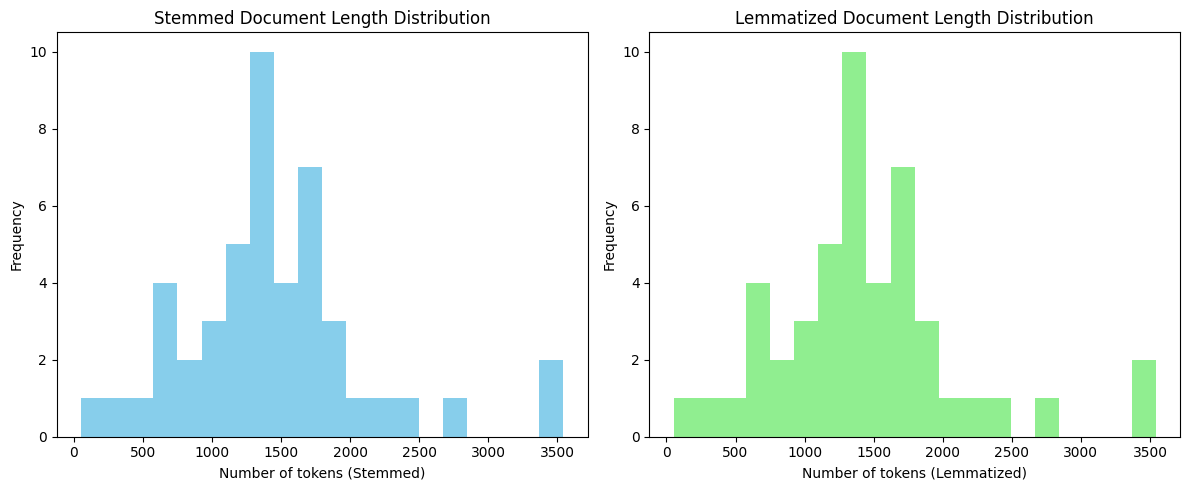

In [94]:
df['stem_length'] = df['stemmed_tokens'].apply(len)
df['lemma_length'] = df['lemmatized_tokens'].apply(len)


print("Stemmed Tokens Length Stats:")
print(df['stem_length'].describe())
print("\nLemmatized Tokens Length Stats:")
print(df['lemma_length'].describe())


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['stem_length'], bins=20, color='skyblue')
plt.xlabel("Number of tokens (Stemmed)")
plt.ylabel("Frequency")
plt.title("Stemmed Document Length Distribution")

plt.subplot(1, 2, 2)
plt.hist(df['lemma_length'], bins=20, color='lightgreen')
plt.xlabel("Number of tokens (Lemmatized)")
plt.ylabel("Frequency")
plt.title("Lemmatized Document Length Distribution")

plt.tight_layout()
plt.show()


### Tf Idf

**Generating the TF-IDF matrix**

In [103]:
df['processed_text'] = df['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()



TF-IDF matrix shape: (47, 5000)


**Analysing the top 5 tf idf scores for each document**

In [104]:
top_terms_all = []

# Loop over each document index in the TF-IDF matrix
for doc_index in range(X_tfidf.shape[0]):
    tfidf_scores = X_tfidf[doc_index].toarray().flatten()
    top_indices = np.argsort(tfidf_scores)[::-1][:5]
    top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
    top_terms_all.append(top_terms)


for i, terms in enumerate(top_terms_all):
    print(f"Document {i}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Document 0:
  الانتاجيه: 0.4980
  انتاجيه: 0.3372
  منتج: 0.2288
  التسويف: 0.1817
  سكور: 0.1245
------
Document 1:
  الاكس: 0.3637
  الفقراء: 0.1677
  الغنى: 0.1514
  إكس: 0.1483
  نظره: 0.1443
------
Document 2:
  الاباحيه: 0.2088
  الإدمان: 0.2088
  الاستخدام: 0.1788
  الاباحي: 0.1788
  الأولاد: 0.1753
------
Document 3:
  العيد: 0.7723
  الانبساط: 0.1261
  لبس العيد: 0.1211
  بالماضي: 0.1211
  بنبسط: 0.1009
------
Document 4:
  عقليه: 0.1949
  الظروف: 0.1860
  الثمن: 0.1508
  تبصش: 0.1508
  الصف: 0.1508
------
Document 5:
  تعس: 0.3249
  الحراسه: 0.2384
  يعطى: 0.2031
  سبيل: 0.1744
  الساقه: 0.1625
------
Document 6:
  القلق: 0.5878
  يحفظك: 0.2204
  احفظ: 0.2204
  وإعلم: 0.1714
  قلق: 0.1714
------
Document 7:
  نوح: 0.2904
  الأذى: 0.2768
  لالاذى: 0.2074
  التنمر: 0.1873
  الإنسان: 0.1259
------
Document 8:
  صديق: 0.3056
  الصديق: 0.1700
  بكر: 0.1586
  بياثر: 0.1470
  الأصدقاء: 0.1470
------
Document 9:
  وسلم: 0.5035
  صلى وسلم: 0.4877
  صلى: 0.4051
  رسول: 0.2928
  بكر: 0.

In [105]:
categories = df['category'].dropna().unique()

for cat in categories:
    print(f"Category: {cat}")
    subset = df[df['category'] == cat]
    
    
    vectorizer_cat = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_cat = vectorizer_cat.fit_transform(subset['processed_text'])
    
    feature_names_cat = vectorizer_cat.get_feature_names_out()
    avg_tfidf = np.array(X_cat.mean(axis=0)).flatten()
    
    
    top_indices = np.argsort(avg_tfidf)[::-1][:5]
    top_terms = [(feature_names_cat[i], avg_tfidf[i]) for i in top_indices if avg_tfidf[i] > 0]
    
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Category: Education
  الإنسان: 0.0838
  وأنا: 0.0586
  وأنت: 0.0452
  لالله: 0.0407
  فأنا: 0.0346
------
Category: People & Blogs
  زبده: 0.0477
  كلب: 0.0403
  الوسخه: 0.0386
  الفطار: 0.0353
  أسبوع: 0.0350
------
Category: Comedy
  رياضه: 0.1351
  سمسم: 0.1249
  بطوله: 0.1009
  ميدو: 0.1000
  سبايدر: 0.0916
------


### Word cloud

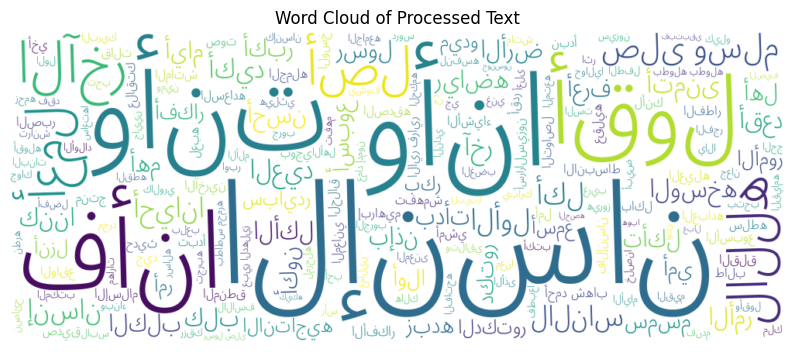

In [116]:

text_combined = " ".join(df['processed_text'])
font_path = "./openjfx-20.0.1_windows-x64_bin-sdk/static/NotoSansArabic_Condensed-Light.ttf"
wordcloud = WordCloud(
    font_path=font_path, 
    width=1000,
    height=400,
    background_color='white'
).generate(text_combined)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()